# Bounding box estimator

**MAI5021 / SCC5830 - Image Processing and Analysis (2022)**

**Author**: Luiz Giordani

The objective of the project is to see if it is possible to detect objects in an image by using outlier detection algorithms. This will be accomplished by splitting the images in a set of non-overlapping patches, and training a machine learning model to detect if that patch potentially has an object.

If this task is sucessful, one could use such methodology to validate image labels, given by an annotator, to the output of the algorithm, hence, uncovering inconsistencies.

On its core, this might not seem like a classical image processing problem, but to get there we will need to apply its principles in different steps:

1. Image pre-processing
   1. Donwsizing
   2. Converting to grayscale

2. Creation of features
   1. Feature descriptors like the histogram of intensities

3. Training and evaluating the outlier detection algorithm

4. Segmentation, to find the bounding boxes
   1. Applying the Otsu segmentation algorithm
   2. Pixel aggregation to create the bounding boxes

We will explain the techniques used and the rationale on each section

## 1- Introduction and preprocessing

We will be using data from [Retail Product Checkout Dataset](https://www.kaggle.com/datasets/diyer22/retail-product-checkout-dataset).

It is a set of high quality images displaying groceries on a white background. Different images have different scales of difficulty, as shown on the example taken from the source:

![](.img/image_source.png "Example from the source")

In [1]:
import pandas as pd
import numpy as np
import imageio
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.util import view_as_blocks
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import product
import json

# Custom functions which abstract many things later
from funcs.preprocessing import read_data
from funcs.plot import show_image, labels_with_otsu
from funcs.ml import (read_images, 
                    images_as_patches, 
                    prediction_intensities, 
                    reconstruct_image, 
                    IntensityHistogram, 
                    train_isoforest, 
                    eval_model)

In [2]:
plt.rcParams['figure.figsize'] = (16,12)

As for preprocessing, we first start by downsizing the images. This is accomplished by applying a gaussian filter as implemented on `skimage` `resize`.

We perform the downsizing for two reasons:
1. Standardizing the shape of the images
2. Reduce the potential computational effort of the task


We also create a copy of the images by converting them to grayscale. The intetion is to test wheter we can detect the objects without color information

In [3]:
# Holds image information and annotations
with open('data/retail_product/instances_val2019.json') as f:
    val_instances_dict = json.load(f)

# Image information as a Pandas DataFrame
validation_images = pd.DataFrame(val_instances_dict['images'])
validation_images['file_name'] = 'data/retail_product/val2019/' + validation_images['file_name'] # Computing the full image path
# Annotations as a Pandas DataFrame
validation_annotations = pd.DataFrame(val_instances_dict['annotations'])

In [4]:
validation_images.head()

file_name  width  height   id level
0  data/retail_product/val2019/20180827-16-07-06-...   1850    1850  220  easy
1  data/retail_product/val2019/20180827-16-07-10-...   1840    1840  221  easy
2  data/retail_product/val2019/20180827-16-24-37-...   1826    1826  222  easy
3  data/retail_product/val2019/20180827-16-24-44-...   1829    1829  223  easy
4  data/retail_product/val2019/20180827-16-24-53-...   1826    1826  224  easy

In [5]:
example = validation_images.loc[validation_images['id']==7388] # Lets use this image to illustrate our examples
example_image = imageio.imread(example.iloc[0, 0]) # taking the filename and reading the image

In [6]:
example_image.shape

(1802, 1802, 3)

Altough every image is square, they differ in size and since the main idea of the project relies on taking non-overlapping patches of the images and detecting wheter there is a glance of an object there, we need to consistently take *n* number of patches of any images to fit and later predict with the model.

For example:
* Take image with id 7388. It is sized as 1802x1802, leading to $1802^2 = 3247204$ pixels

    A patch size of 200 will produce $3247204/(200^2) ~= 81.18$ patches. Therefore, to fit a equal number of patches we would have to either pad or crop the image. The first adding unnecessary noise while the second might leave information out.

Since we are in a situation where some loss of information seems inevitable, might be easier to just downsize the images, as to somewhat keeps its integrity. This has some benefits:

1. For a image in a power of 2, we can try a wide range of patch sizes that are also a power of 2, such as 64, 16, 8... Each with its own pros and cons, but all will always give patches that cover the whole image
2. Lower memory usage which can lead to the use of more images

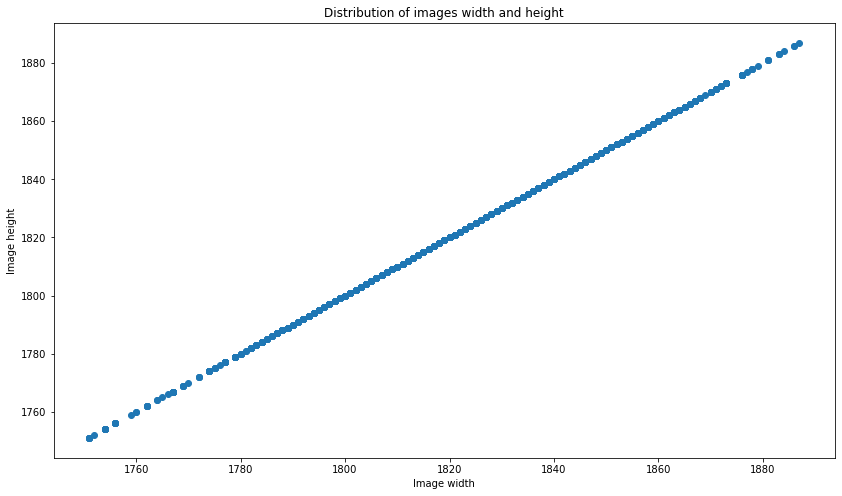

In [7]:
fig, ax = plt.subplots(figsize=(14,8))

ax.scatter(validation_images['width'], validation_images['height'])
ax.set_xlabel('Image width')
ax.set_ylabel('Image height')
ax.set_title('Distribution of images width and height')

plt.show()

The resized image seems a little off-center when compared to the original image. But otherwise, there is little perceptible difference.

For more details, check the [02 - preproceess](02_preprocess.ipynb]) notebook

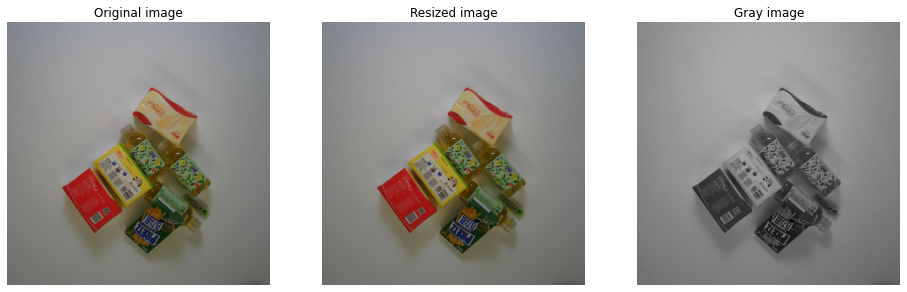

In [8]:
resized_example = resize(example_image, (1024, 1024), preserve_range=True).astype(np.uint8)
gray_img = (rgb2gray(resized_example)*255).astype(np.uint8) # Multypling by 255 since the function rescales the image to 0-1 scale

fig, axs = plt.subplots(ncols=3)

axs[0].imshow(example_image)
axs[0].set_title('Original image')

axs[1].imshow(resized_example)
axs[1].set_title('Resized image')

axs[2].imshow(gray_img, cmap='gray')
axs[2].set_title('Gray image')

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

plt.show()

## 2- Image descriptors

First of all, it is important to illustrate how the images will look for the algorithm. How the patches will be created and what exactly that means.

Let's start with a silly example, dividing our grayscaled image in 4

In [9]:
img_blocks = view_as_blocks(gray_img, (512,512)).reshape(-1, 512, 512) # Since it is a 1024x1024 we find for blocks of 512x512

img_blocks.shape

(4, 512, 512)

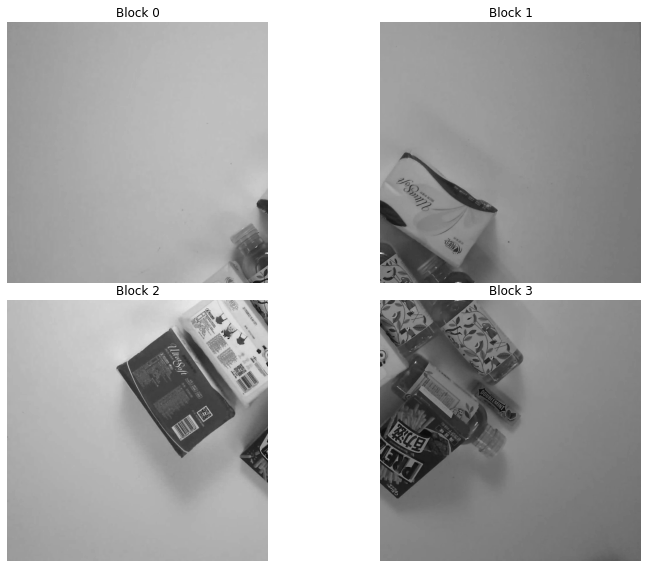

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

axs = axs.flatten()

for i, ax in zip(range(img_blocks.shape[0]), axs):

    ax.imshow(img_blocks[i, :, :], cmap='gray')
    ax.set_title(f'Block {i}')
    ax.axis('off')

fig.tight_layout(h_pad=0.1)
plt.show()

Now we have to transform this image into something that our algorithm can understand. One way to do this is by using image descriptors.

For this project we applied only the intensity histogram, and for our example it would look something like this:

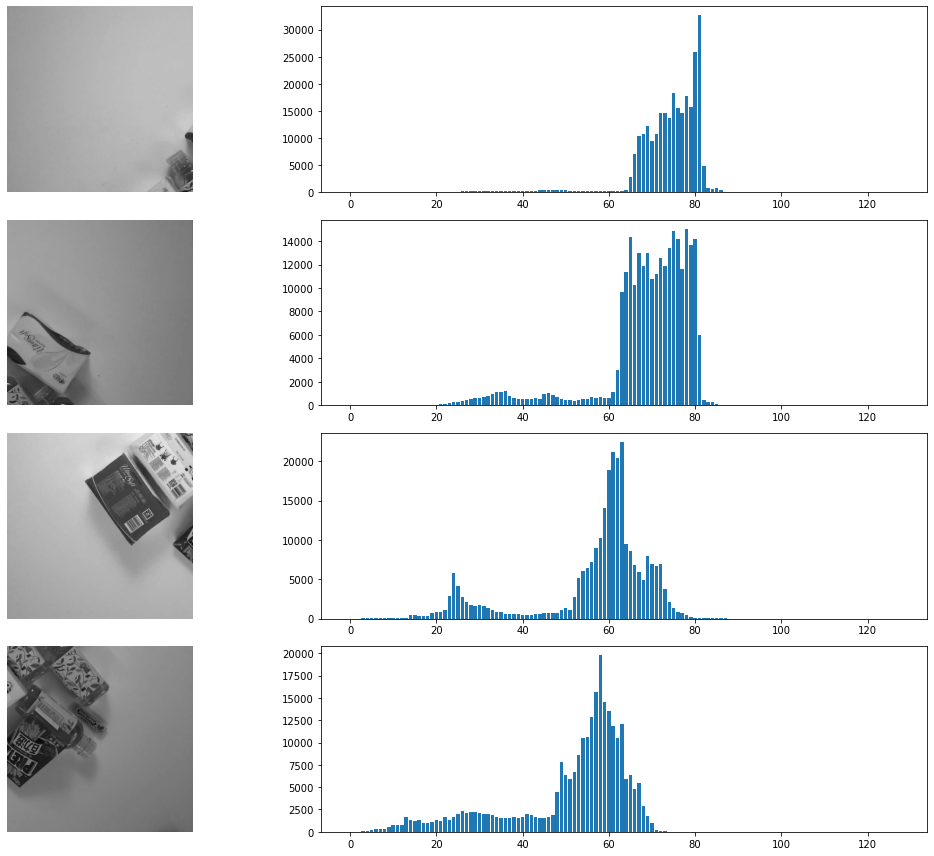

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=2)

for i in range(img_blocks.shape[0]):

    hist, edges = np.histogram(img_blocks[i, :, :], bins=128, range=(0, 255))
    axs[i, 0].imshow(img_blocks[i, :, :], cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].bar(range(128), hist)

fig.tight_layout()
plt.show()

It actually seems like the histogram is shaped differently on the images that have less background (and more objects) on its overall area!

When fitting the algorithm, we will normalize the histogram.

For color images we will perform the color histogram for each channel and concatenate the resulting distributions.

More details can be seen on [03 - Algorithm](03_algorithm.ipynb) notebook and the [IntensityHistogram](funcs/ml.py) method implemented.

## 3- Outlier detection

For outlier detection, we will use the [Isolation Forest Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) which is a tree based method that splits the tree trying to separate each sample into a single leaf.

Moreover, it returns an outlier score for each of our patches that we can later use to reconstruct an image-like matrix of outlier propensities

To fit and evaluate the algorithm we need to first read some more data.

We will use two random samples:

1. Train: 70 images
2. Validation: 20 images

To quick things up, we will read two previously saved dataframes that hold information on our selected images.

For more details on the selection check [01 - Take samples](01_take_samples.ipynb)

### Reading the images

In [12]:
gray_train_val_images, train_val_annotations = read_data('gray_', 'resized_')
color_train_val_images, _ = read_data('resized_', 'resized_') # The annotations are the same, so we can discard them here

In [13]:
gray_train_val_images.head()

id   level  n_pixels source  width  height  width_ratio  height_ratio  \
0   7388    easy   1048576  train   1024    1024     0.568257      0.568257   
1  11456  medium   1048576  train   1024    1024     0.556522      0.556522   
2  13038  medium   1048576  train   1024    1024     0.559257      0.559257   
3  19004  medium   1048576  train   1024    1024     0.558952      0.558952   
4  19043  medium   1048576  train   1024    1024     0.571429      0.571429   

                                           file_name  
0  data/retail_product/sampled_images/gray_7388_t...  
1  data/retail_product/sampled_images/gray_11456_...  
2  data/retail_product/sampled_images/gray_13038_...  
3  data/retail_product/sampled_images/gray_19004_...  
4  data/retail_product/sampled_images/gray_19043_...

In [14]:
train_val_annotations.head()

area                              bbox  category_id    id  image_id  \
0   62966.28   [568.83, 580.23, 201.49, 97.74]          131  2203       583   
1  175741.49  [290.65, 545.24, 215.03, 255.63]           64  2204       583   
2  164760.36  [126.75, 468.41, 160.89, 320.29]          170  2205       583   
3  174151.07   [281.63, 240.4, 219.54, 248.11]           64  2206       583   
4  112336.58   [445.5, 207.77, 103.26, 342.48]           75  2852       729   

   iscrowd segmentation          point_xy  
0        0         [[]]   [669.58, 629.1]  
1        0         [[]]  [398.17, 673.05]  
2        0         [[]]   [207.2, 628.55]  
3        0         [[]]   [391.4, 364.45]  
4        0         [[]]  [497.13, 379.01]

The data is ordered sequentially in train and validation, so we can take the indexes to later split the array holding all images

In [15]:
train_idx = gray_train_val_images.loc[gray_train_val_images['source']=='train'].index.max()
val_idx = gray_train_val_images.loc[gray_train_val_images['source']=='validation'].index.max()

More details on the following custom functions can be found on [ml.py](funcs/ml.py)

In [16]:
# Gray images
imgs_array = read_images(gray_train_val_images['file_name']) # Function to iterate over all the filenames and return all images, as an array

train_imgs = imgs_array[:train_idx+1, :, :].copy()
val_imgs = imgs_array[train_idx+1:val_idx+1, :, :].copy()

# Color images
color_imgs_array = read_images(color_train_val_images['file_name'], color=True)

color_train_imgs = color_imgs_array[:train_idx+1, :, :].copy()
color_val_imgs = color_imgs_array[train_idx+1:val_idx+1, :, :].copy()

In [17]:
print(imgs_array.shape)
print(train_imgs.shape)
print(val_imgs.shape)

(100, 1024, 1024)
(70, 1024, 1024)
(20, 1024, 1024)


Now we can finally create our patches. We will use a size of 64x64 which should yield 256 non-overlapping patches for each image.

In [18]:
gray_patch_size = (1, 64, 64) # The 1 is to make sure that the function reads each index, on the first dimension, as a single image
color_patch_size = (1, 64, 64, 3)


# Splits the data into patches and takes the flatten array, as the for the histogram we do not need the matrix format
train_set = images_as_patches(train_imgs, gray_patch_size)
val_set = images_as_patches(val_imgs, gray_patch_size)

color_train_set = images_as_patches(color_train_imgs, color_patch_size)
color_val_set = images_as_patches(color_val_imgs, color_patch_size)

In [19]:
print(train_set.shape)
print(val_set.shape)
print(color_train_set.shape)
print(color_val_set.shape)

(17920, 4096)
(5120, 4096)
(17920, 4096, 3)
(5120, 4096, 3)


### Fitting the Isolation Forest

We will try models with different number of bins on the histogram, maybe being more or less specific can have significant changes on the detection power of the algorithm.

Moreover, to evaluate the performance of each set of parameters, we will use the [Silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) a metric that has its origins on cluster analysis. The score states the average silhouette score of each sample and values closer to -1 indicate that the sample is in the wrong cluster, while closer to 1 states that the sample is in a cluster with similar samples.

The use of the score makes some sense, since we are working on an unsupervised task and by default the isolation forest tries to find an ideal split point to label each sample as an outlier or not. While it might not be the precise label we want, it still need to split the samples into fairly consistent groups.

In [20]:
# Dictionary to test our different parameters. For color images we are actually creating 3 histograms of nbins size and concatenating them.
models_dict = {
    'gray_64': {'method': 'grayscale', 'nbins': 64},
    'gray_128': {'method': 'grayscale', 'nbins': 128},
    'gray_255': {'method': 'grayscale', 'nbins': 255},
    'color_16': {'method': 'color', 'nbins': 16},
    'color_32': {'method': 'color', 'nbins': 32},
    'color_64': {'method': 'color', 'nbins': 64},
    'color_128': {'method': 'color', 'nbins': 128}
}

More information abour the custom functions used can be found at [ml.py](funcs/ml.py)

In [21]:
# Fitting each model and holding the pipeline and silhouette scores
for feature_type, params in models_dict.items():
    print(f'Fitting iso forest for: {feature_type}')

    if params['method']=='grayscale':
        pipeline = train_isoforest(train_set, params['nbins']) # Takes a training set and return the isolation forest sklearn object
        params['train_score'] = eval_model(train_set, pipeline) # Sillhouette score for a given set of images
        params['val_score'] = eval_model(val_set, pipeline) 
    else:
        pipeline = train_isoforest(color_train_set, params['nbins'])
        params['train_score'] = eval_model(color_train_set, pipeline)
        params['val_score'] = eval_model(color_val_set, pipeline)
    
    params['pipeline'] = pipeline
    print('-'*10)

Fitting iso forest for: gray_64
----------
Fitting iso forest for: gray_128
----------
Fitting iso forest for: gray_255
----------
Fitting iso forest for: color_16
----------
Fitting iso forest for: color_32
----------
Fitting iso forest for: color_64
----------
Fitting iso forest for: color_128
----------


In [22]:
results_df = (pd.DataFrame(models_dict)
                .T
                .reset_index()
                .rename(columns={'index': 'model_name'})
                .drop(columns=['pipeline'])
            )

We see some differences in performance according to the sillhouette score between images trained with color vs. grayscale.

In addition, it seems to have some differences in performance byembedding more information by using lower number of bins.

**Quick note:** The silhouette score is negative for our training, so to make the visualization easier we multiply by -1, meaning that a score closer to 0 is better.

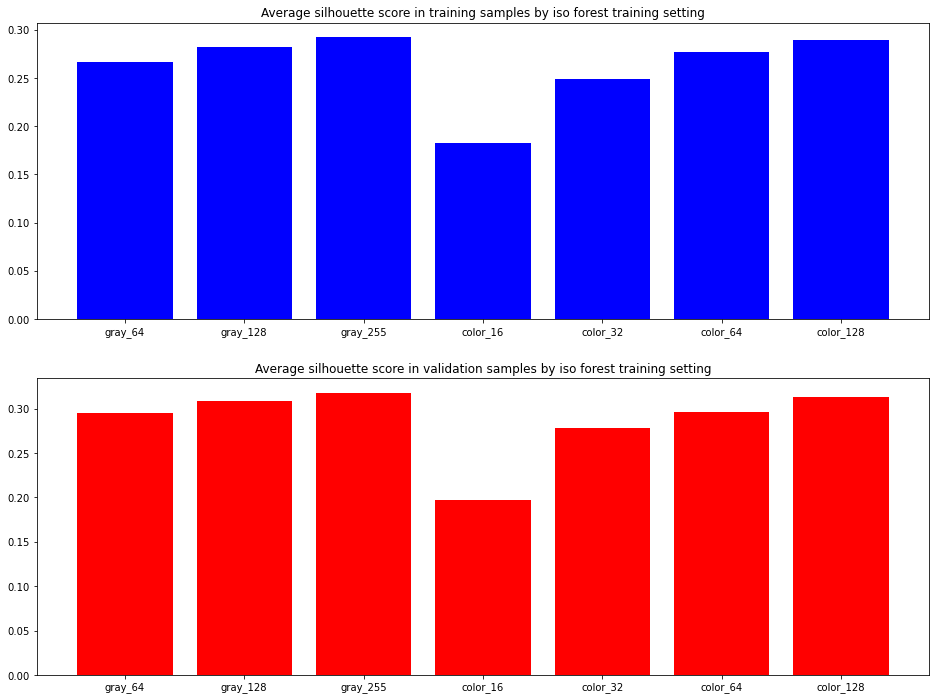

In [23]:
fig, axs = plt.subplots(nrows=2, figsize=(16,12))

# Multiplying by -1 since all values are negative, hence, making it easier to visualize
axs[0].bar(results_df['model_name'], results_df['train_score']*-1, color='blue')
axs[0].set_title('Average silhouette score in training samples by iso forest training setting')

axs[1].bar(results_df['model_name'], results_df['val_score']*-1, color='red')
axs[1].set_title('Average silhouette score in validation samples by iso forest training setting')

plt.show()


### Visualizing results

Let's compare how the best configuration, `color_16` differs from the worst `gray_255`

For this, let's look at some prediction on our validation sample.

More views can be seen on [03 - Algorithm](03_algorithm.ipynb)

Overall, both algorithms seems to make similar predictions, with the one trained on the color images being more intense.

**Note**: More intense predictions = Higher probability of an outlier

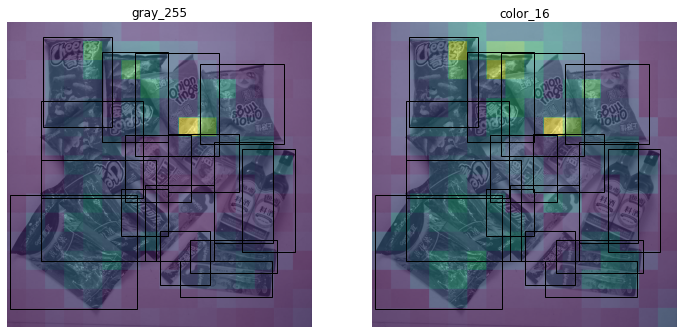

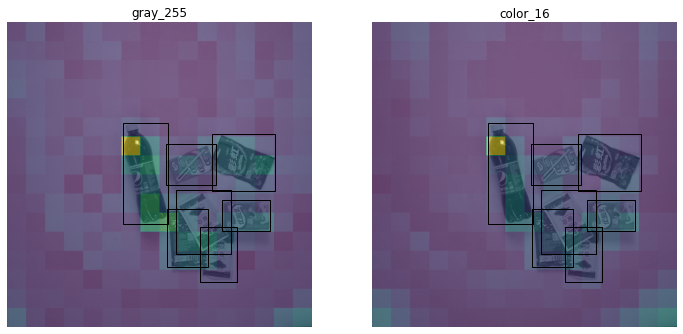

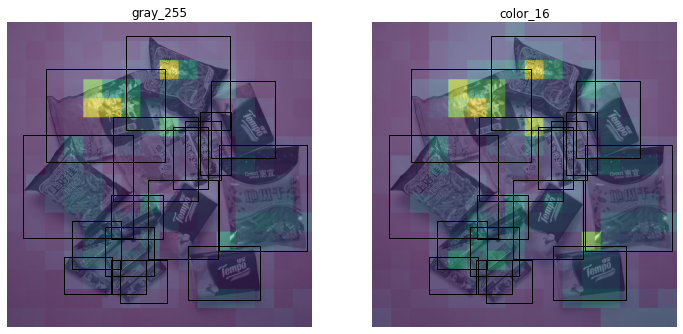

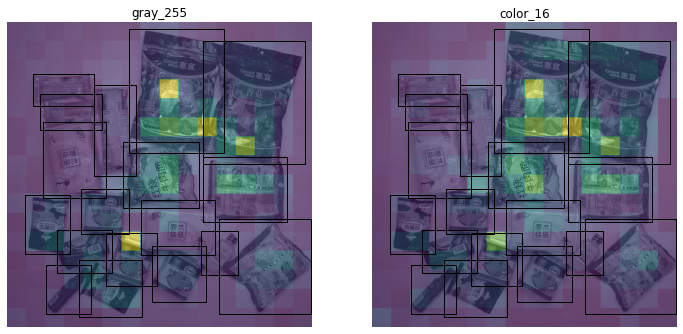

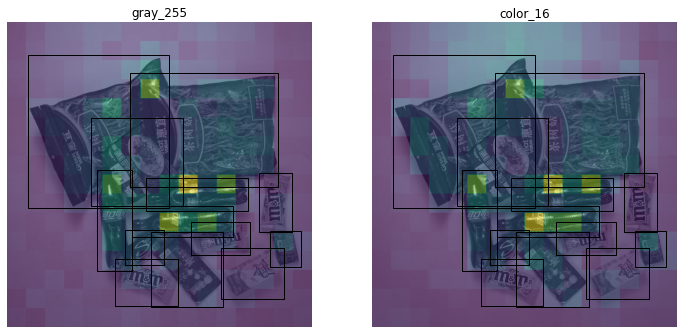

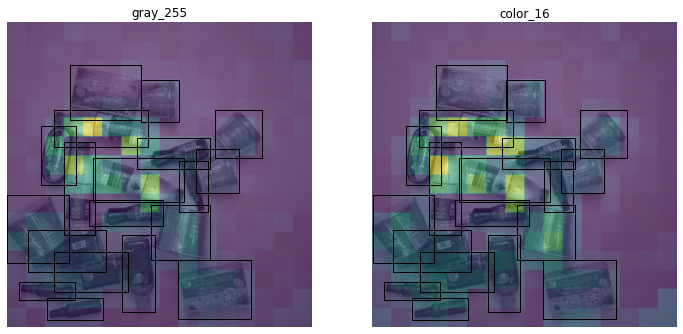

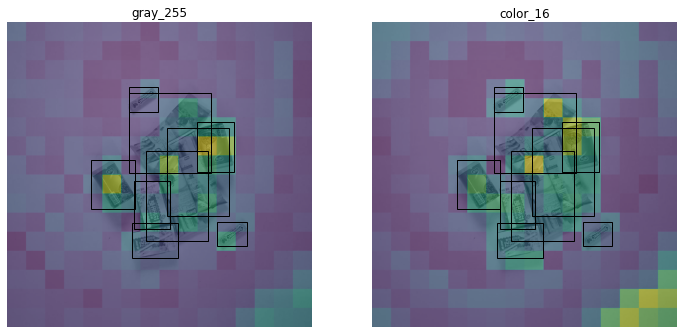

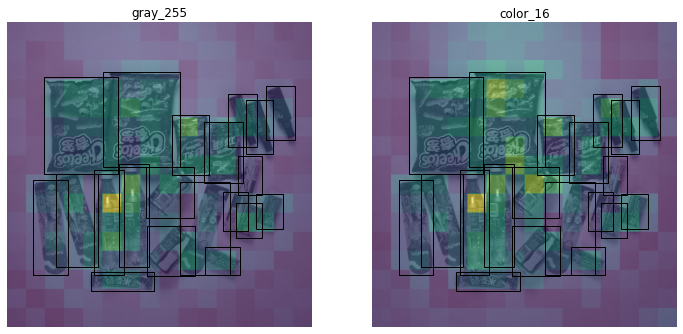

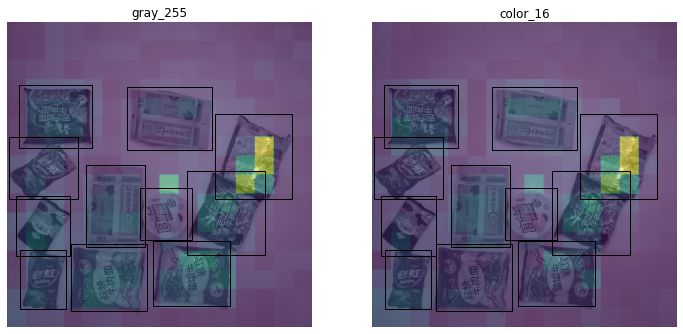

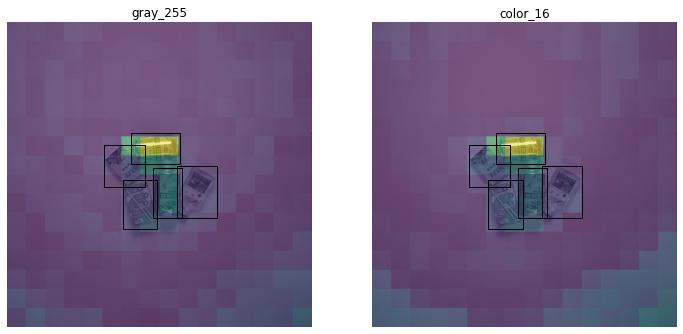

In [24]:
val_df = gray_train_val_images.loc[gray_train_val_images['source']=='validation']
color_val_df = color_train_val_images.loc[color_train_val_images['source']=='validation']

for i in range(10):

    fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
    # Builds an image like array with the outlier scores given by the model. We rescale these to be between 0 and 1. 
    # Higher values indicate that the pixel/patch is more likely to be an outlier
    predictions = prediction_intensities(models_dict['gray_255']['pipeline'], val_imgs[i], (64, 64))
    color_predictions = prediction_intensities(models_dict['color_16']['pipeline'], color_val_imgs[i], (64, 64, 3))
    id = val_df.iloc[i]['id']

    # Grayscale on column 0
    show_image(id, gray_train_val_images, True, train_val_annotations, ax=ax[0])
    ax[0].imshow(predictions, alpha=0.5)
    ax[0].axis('off')
    # Color predictions on column 1
    show_image(id, gray_train_val_images, True, train_val_annotations, ax=ax[1])
    ax[1].imshow(color_predictions, alpha=0.5)
    ax[1].axis('off')

    ax[0].set_title('gray_255')
    ax[1].set_title('color_16')

    plt.show()


Remaining 10

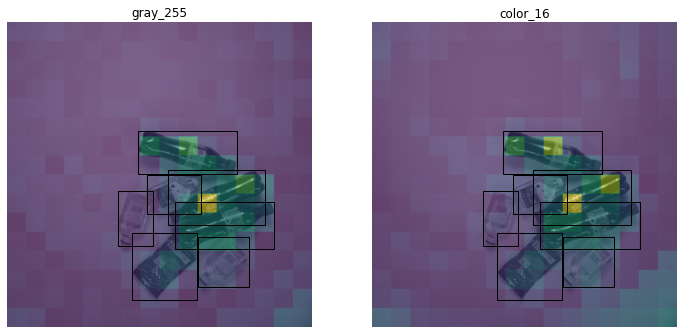

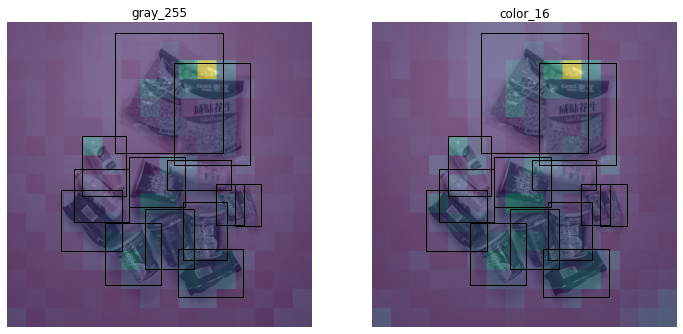

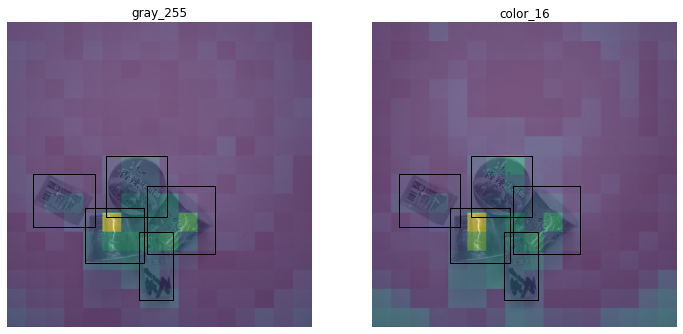

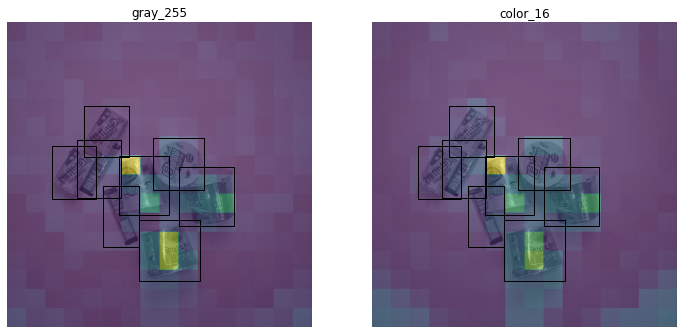

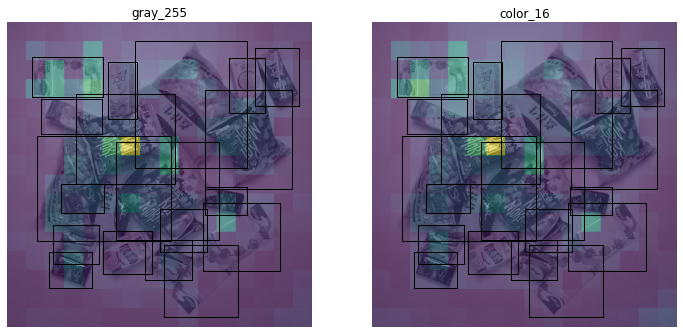

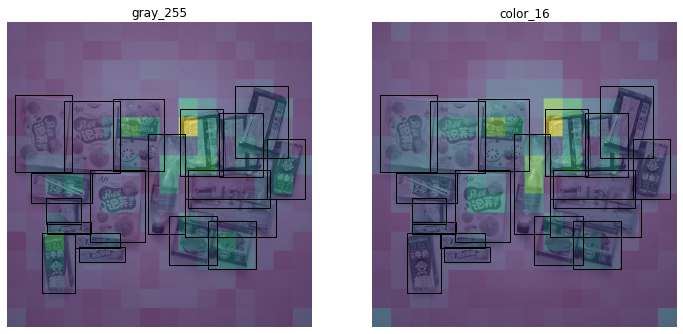

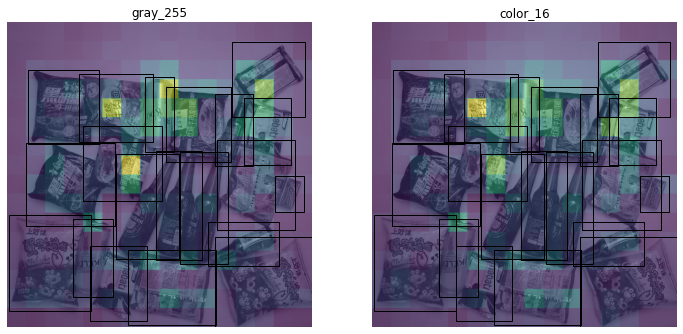

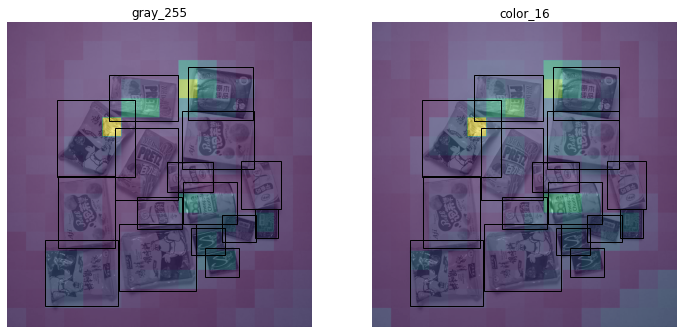

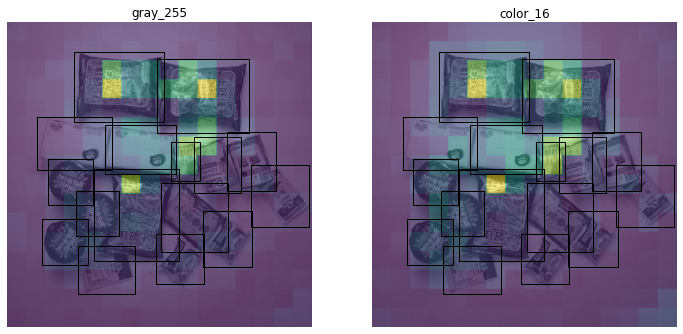

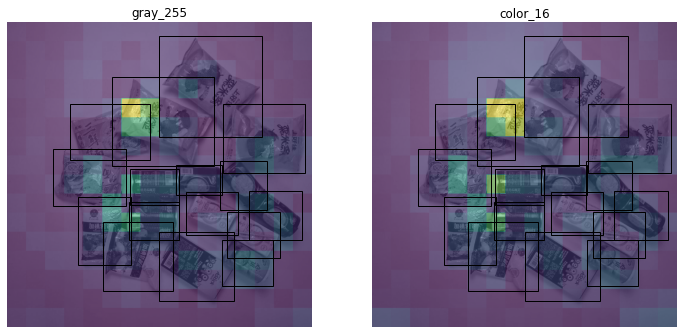

In [25]:
for i in range(10, 20):

    fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
    predictions = prediction_intensities(models_dict['gray_255']['pipeline'], val_imgs[i], (64, 64))
    color_predictions = prediction_intensities(models_dict['color_16']['pipeline'], color_val_imgs[i], (64, 64, 3))
    id = val_df.iloc[i]['id']

    # Grayscale on column 0
    show_image(id, gray_train_val_images, True, train_val_annotations, ax=ax[0])
    ax[0].imshow(predictions, alpha=0.5)
    ax[0].axis('off')
    # Color predictions on column 1
    show_image(id, gray_train_val_images, True, train_val_annotations, ax=ax[1])
    ax[1].imshow(color_predictions, alpha=0.5)
    ax[1].axis('off')

    ax[0].set_title('gray_255')
    ax[1].set_title('color_16')

    plt.show()

## 4- Segmentation

Hopefully we have a reasonable algorithm that can detect the objects, now we need to find a way to estimate the bounding boxes.

As shown on the previous sections, we can assume that our predictions are intensities over our images, moreover, we are viewing them on a scale from 0 to 1.

Therefore, we can try to visualize these intensity distribution on as a intensity range between 0-255 and apply some sort of split on the histogram of predictions

In [26]:
hist_pos_ids = np.random.randint(low=0, high=color_val_imgs.shape[0], size=5) # Let's take a sample of images
hist_sample_ids = color_val_df['id'].iloc[hist_pos_ids].values

Visualize the histogram of predicted outlier intensities of the sample

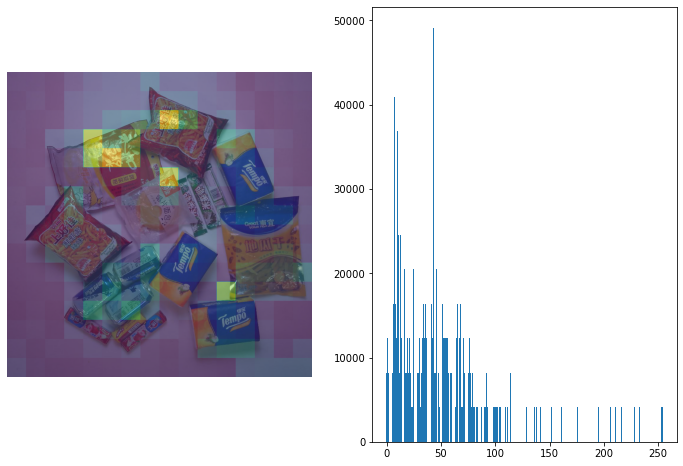

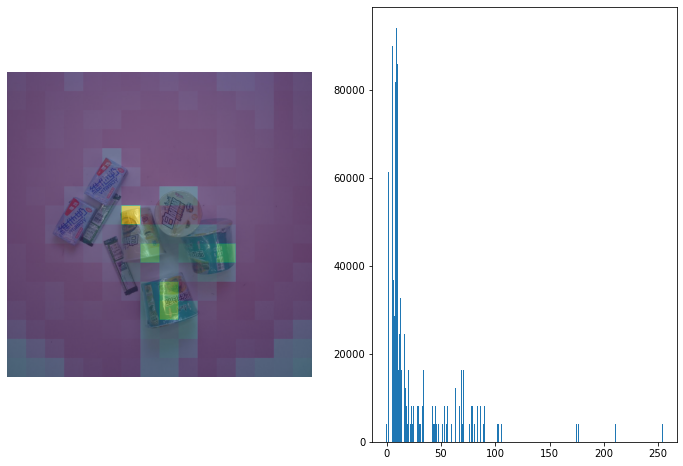

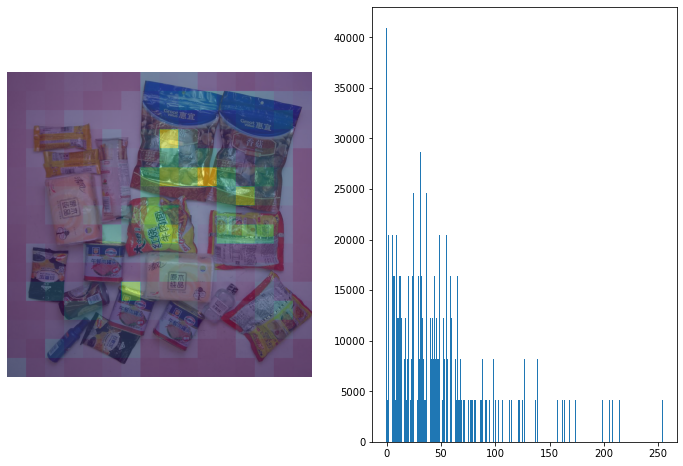

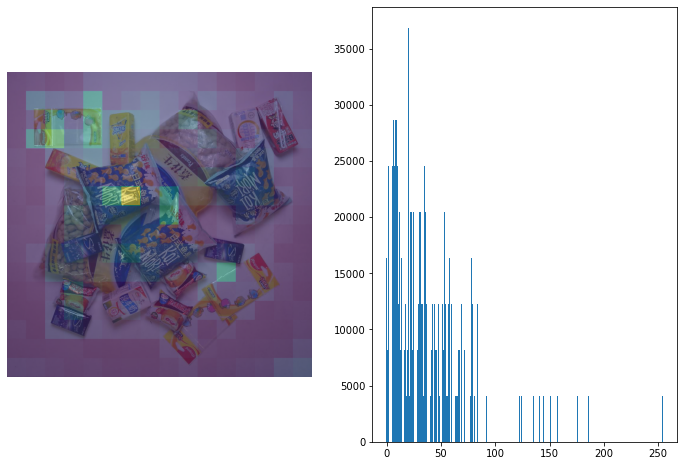

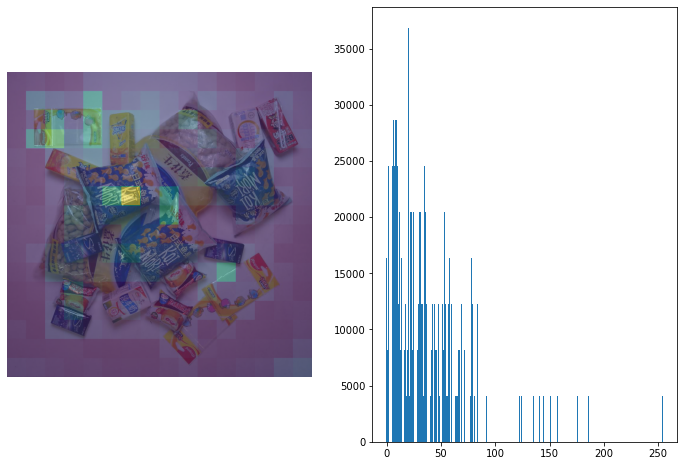

In [27]:
for pos_id, id, i in zip(hist_pos_ids, hist_sample_ids, range(5)):
    
    fig, axs = plt.subplots(ncols=2, figsize=(12,8))

    # Transforim to grayscale, as required
    predicted_as_grayscale = (prediction_intensities(models_dict['color_16']['pipeline'], color_val_imgs[pos_id], (64, 64, 3))*255).astype(np.uint8)
    show_image(id, color_val_df, ax=axs[0])
    axs[0].imshow(predicted_as_grayscale, alpha=0.5)
    prediction_histogram, _ = np.histogram(predicted_as_grayscale, bins=255, range=(0, 255))
    axs[1].bar(range(255), prediction_histogram)

    plt.show()
    

It seems that might be some spaces on the histogram where we can possibly split the intensities into two groups of background and object.

A suggested method to do this is the Otsu method. Let's see how it applies on our results

Based on this [tutorial](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html#sphx-glr-auto-examples-segmentation-plot-label-py) from skimage

In [28]:
otsu_img_example = (prediction_intensities(models_dict['color_16']['pipeline'], color_val_imgs[1], (64, 64, 3))*255).astype(np.uint8)
trsh = threshold_otsu(otsu_img_example)
binary_img_example = otsu_img_example > trsh

# Performs something similar to pixel aggregation on binary images by aggregating images from the same intensity (1 or 0 in this case)
label_img = label(binary_img_example)

The result is not very good, but that might be because of bad luck...

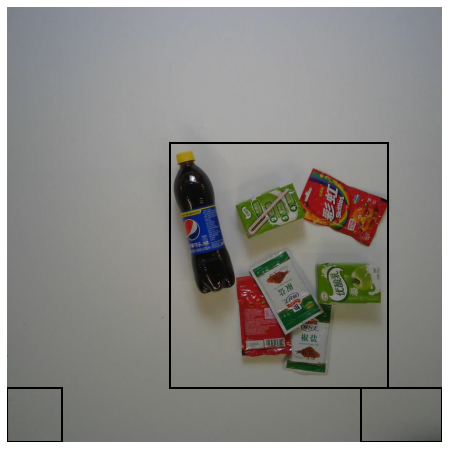

In [29]:
fig, ax = plt.subplots(figsize=(12,8))

ax.imshow(color_val_imgs[1].astype(np.uint8))
ax.axis('off')

for region in regionprops(label_img):

    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(rect)

plt.show()

Let's look at all images. Moreover, we will take this chance to also compare what applying the same segmentation process to the original, grayscale, produces.

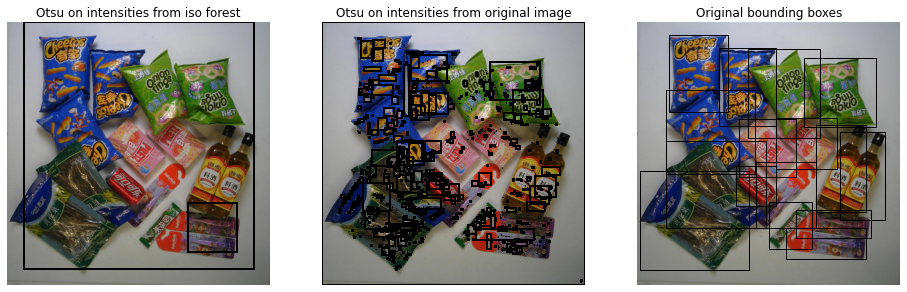

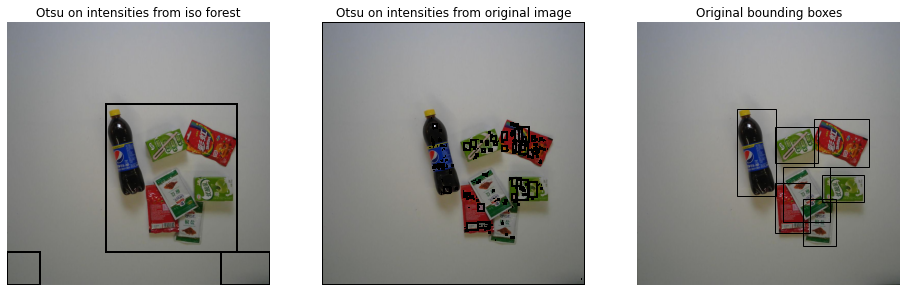

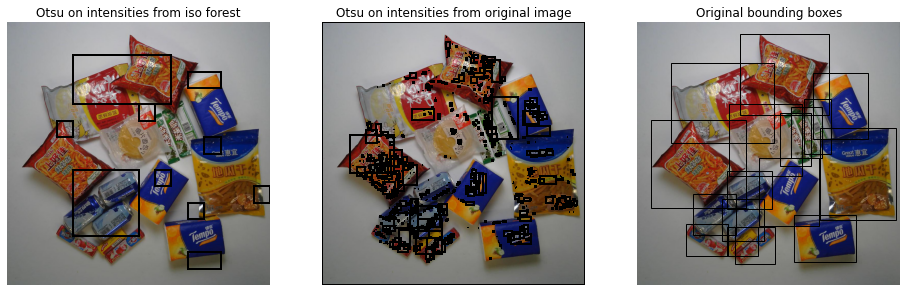

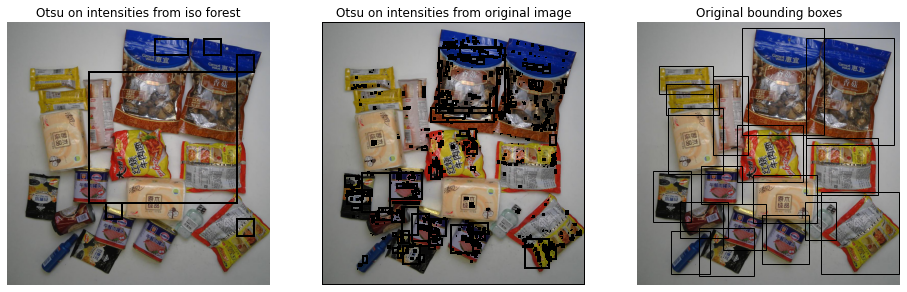

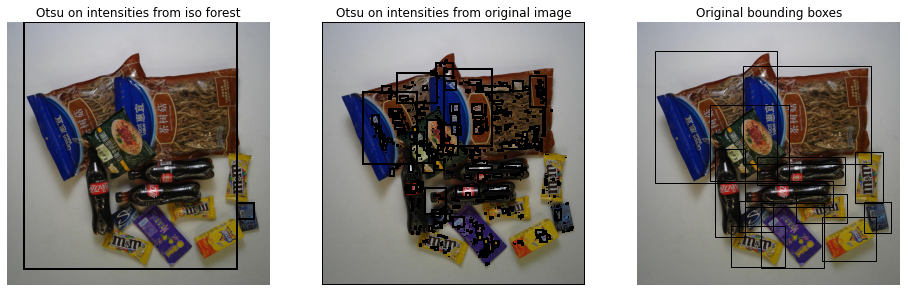

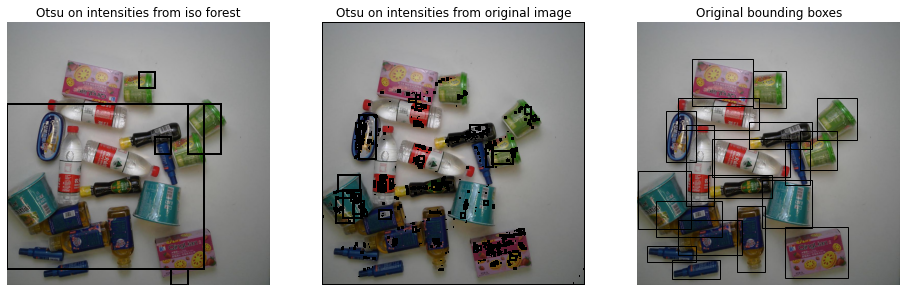

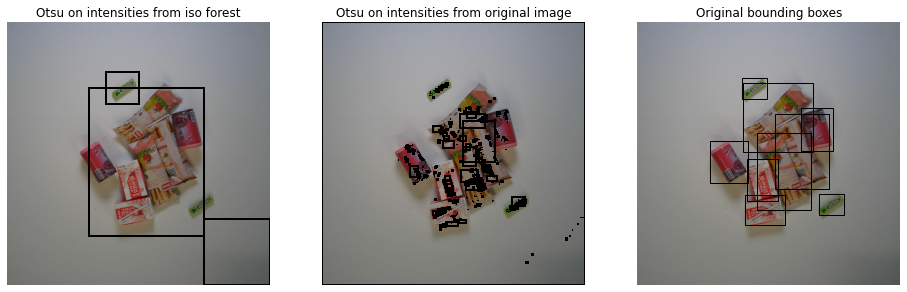

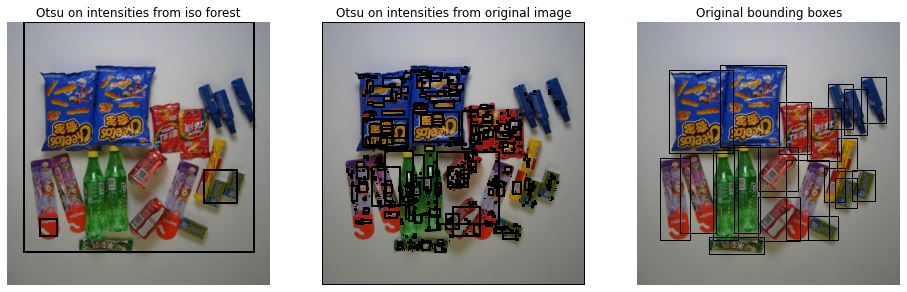

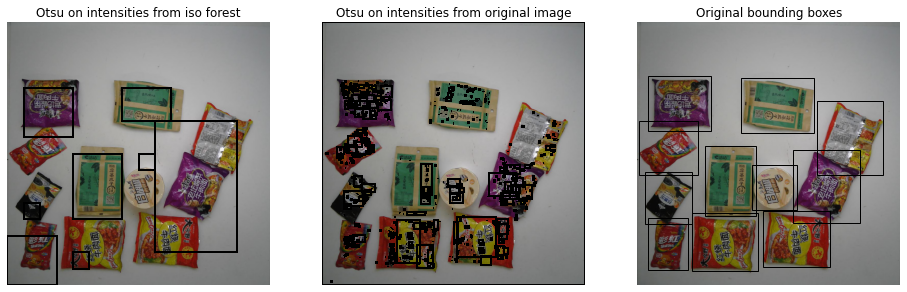

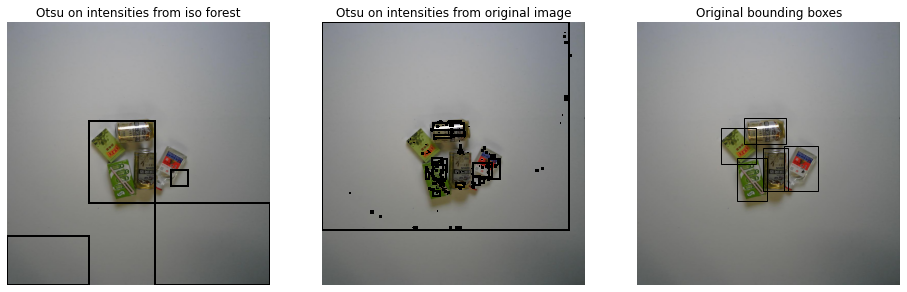

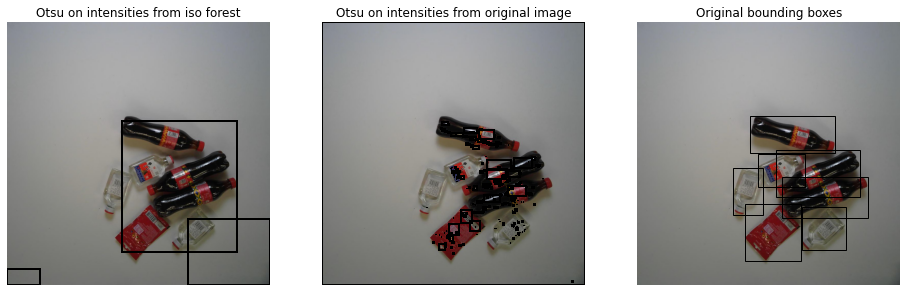

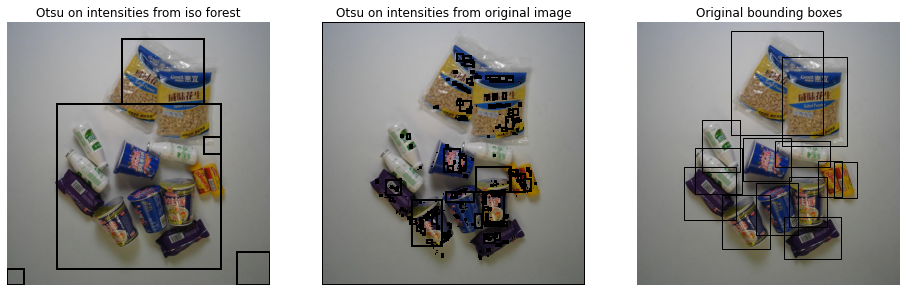

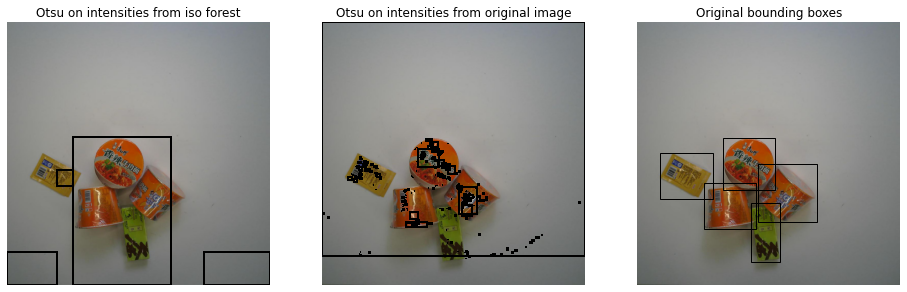

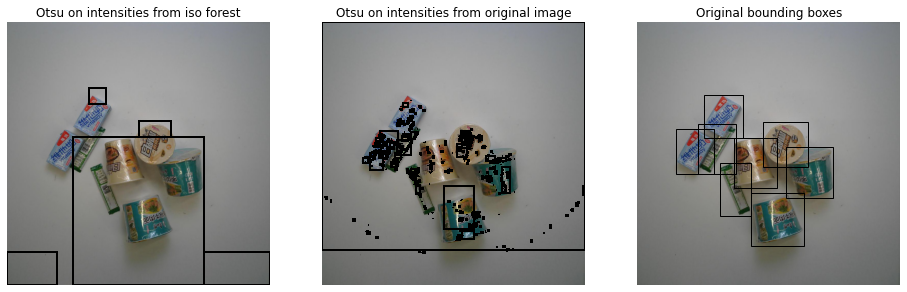

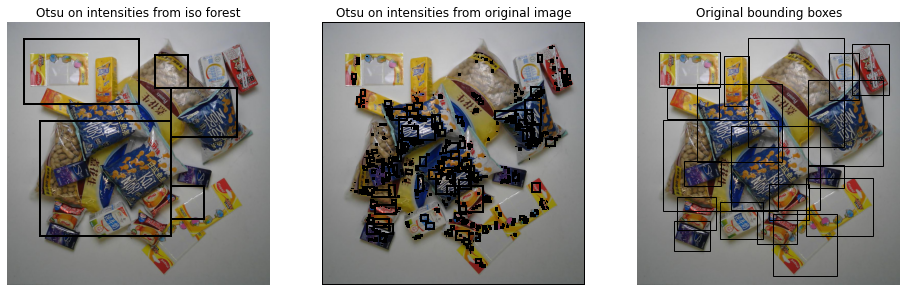

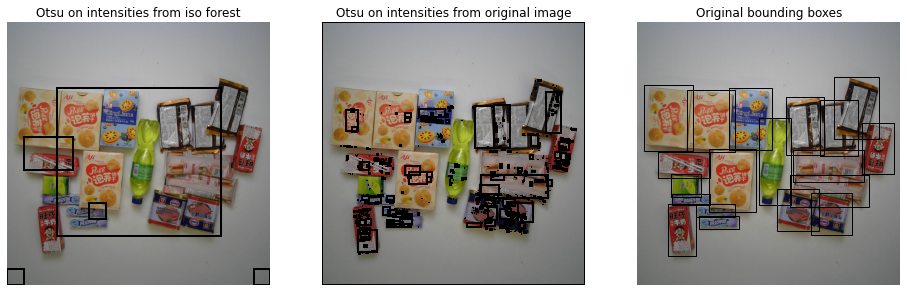

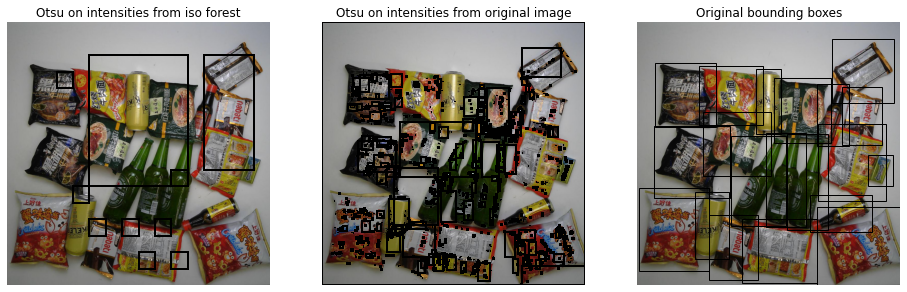

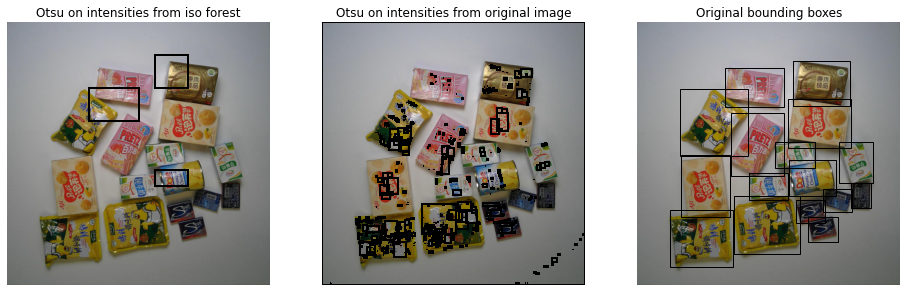

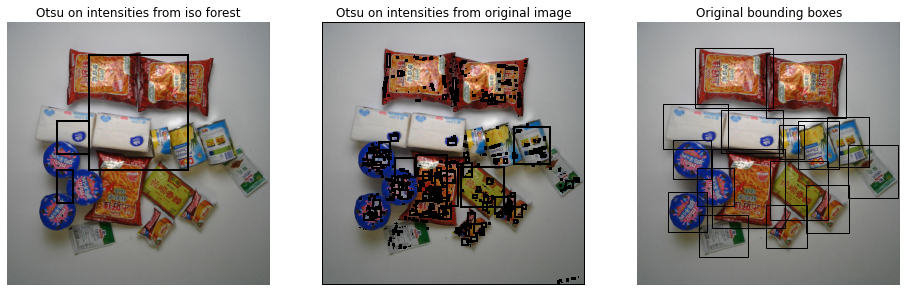

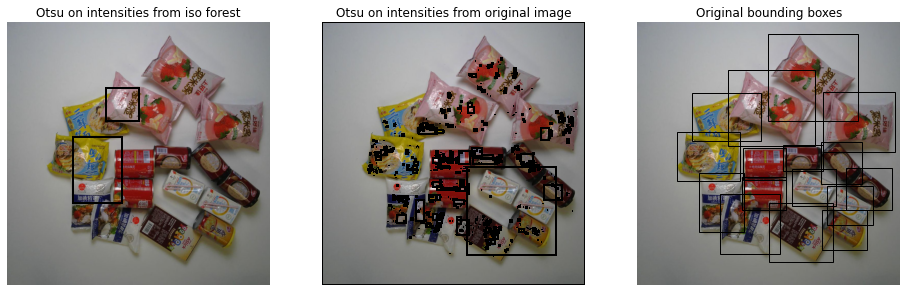

In [30]:
for i in range(color_val_imgs.shape[0]):

    fig, ax = plt.subplots(ncols=3, figsize=(16,12))

    current_img = color_val_imgs[i]
    gray_img = val_imgs[i]
    current_id = color_val_df.iloc[i]['id']

    outlier_intensities = (prediction_intensities(models_dict['color_16']['pipeline'], current_img, (64, 64, 3))*255).astype(np.uint8)
    outlier_labels = labels_with_otsu(outlier_intensities) # Function to wrap up what we did on our past example
    as_is_labels = labels_with_otsu(gray_img)

    ax[0].imshow(current_img.astype(np.uint8))
    ax[1].imshow(current_img.astype(np.uint8))
    show_image(current_id, color_val_df, True, train_val_annotations, ax[2])

    for region in outlier_labels:

        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='black', linewidth=2)
        ax[0].add_patch(rect)

    for region in as_is_labels:

        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='black', linewidth=2)
        ax[1].add_patch(rect)

    ax[0].axis('off')
    ax[1].axis('off')

    ax[0].set_title('Otsu on intensities from iso forest')
    ax[1].set_title('Otsu on intensities from original image')
    ax[2].set_title('Original bounding boxes')


plt.show()


We definitely find some products, however, mostly a cluster of them.

Despite that, our outlier detection is much better and consistent than the naive method. Although it is nowhere near the original bounding boxes.

It seems that the model is not very specific and that could be due to the patch size we selected. But we will discuss this further.

## 5- Lessons learned

Through this experience there were several conclusions, things that could be made different or better. Here the idea is discuss some of them.

1. **Object detection is hard**: At least trying to do it naively. It is no wonder that state of the art methods using vast amounts of data and computing power. Even in cases where annotated labels are available, it is a considerable amount of annotated data.
2. **The trained model is not very good**: And there could be several reasons for this, such as the patch size being too big, which makes the model less specific. Another thing that could help is adding more descriptors such as haralick descriptors or even a PCA of the pixel intensity in each patch. Finally, the dataset is quite hard too, objects are very clustered and very often there are too many objects in the image. However, in this case, we could just train the model using only the easy images. Since the methodology makes no assumption of what is in the image, it would generalize.
3. **Smoothing the intensites could do wonders**: Apart from downsizing the images, making the intensities more smooth could help. Take for example the edges of most images, it always contains some shadow that could be creating more noise.
4. **Other outlier detection algorithms are probably better**: Good results on outlier detection can be achieved using methods that rebuilds the input. In this case of images, one could just work a little more with the data and extract segments of the image that don't have any objects, estimate a model to learn how to rebuild this background patches, and later apply it to the full image. Some models that could perform this task are PCA and Variational Auto Encoders.